In [1]:
# Installing necessary packages for rendering in Google Colab
!apt-get update
!apt install xvfb
!apt-get install x11-utils > /dev/null 2>&1
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,851 kB]
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,389 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/res

In [2]:
# Import necessary libraries
import random
import copy
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import gym
import numpy as np
import torch
import time
import seaborn as sns


In [12]:
# Define the Agent class
class Agent:
    def __init__(self, num_input, num_output):
        # Initialize the agent with the number of inputs and outputs
        self.num_input = num_input
        self.num_output = num_output
        # Calculate the total number of genes (weights and biases)
        self.num_genes = num_input * num_output + num_output
        # Initialize weights and biases as None
        self.weights = None
        self.bias = None

    def set_genes(self, gene):
        # Set the genes (weights and biases) from a given gene array
        weight_idxs = self.num_input * self.num_output
        bias_idxs = self.num_input * self.num_output + self.num_output
        w = gene[0:weight_idxs].reshape(self.num_output, self.num_input).astype(np.float32)
        b = gene[weight_idxs:bias_idxs].reshape(self.num_output,).astype(np.float32)
        self.weights = torch.from_numpy(w)
        self.bias = torch.from_numpy(b)

    def forward(self, x):
        # Perform a forward pass with the current weights and biases
        x = torch.from_numpy(x).unsqueeze(0)
        return torch.mm(x, self.weights.T) + self.bias

    def get_action(self, x):
        # Get the action based on the forward pass output
        if self.forward(x) > 0:
            return 1
        else:
            return 0



In [13]:
# Function to run an episode and calculate the total reward
def run_episode(env, agent):
    tot_reward = 0.0
    obs = env.reset()
    done = False
    # Loop until the episode is done
    while not done:
        action = agent.get_action(obs)
        obs, reward, done, info = env.step(action)
        tot_reward = tot_reward + reward
    return tot_reward

# Function to visualize the agent's performance
def visual_episode(env, agent=None):
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()
    prev_screen = env.render(mode='rgb_array')
    plt.imshow(prev_screen)

    tot_reward = 0.0
    obs = env.reset()
    done = False
    curr_t = 0
    # Loop until the episode is done, rendering each step
    while not done:
        if agent is not None:
            action = agent.get_action(obs)
        else:
            action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        screen = env.render(mode='rgb_array')
        tot_reward = tot_reward + reward

        plt.imshow(screen)
        plt.title(curr_t)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())
        curr_t = curr_t + 1

    ipythondisplay.clear_output(wait=True)
    env.close()
    return tot_reward


# Function to calculate fitness of the population
def fitness_function(env, agent, gene_pop):
    pop_size = gene_pop.shape[0]
    pop_fitness = np.zeros(pop_size)
    # Evaluate each gene in the population
    for i, gene in enumerate(gene_pop):
        agent.set_genes(gene)
        pop_fitness[i] = run_episode(env, agent)
    return pop_fitness


In [14]:
# Define the mutation function
def complex_mutation_function(gene_pop, fitness, mean=0, base_std=0.1, dynamic_adjustment=True, adjustment_factor=0.05):
    new_gene_pop = np.copy(gene_pop)
    std = base_std

    if dynamic_adjustment:
        # Adjust mutation std based on fitness performance
        avg_fitness = np.mean(fitness)
        max_fitness = np.max(fitness)
        std = base_std + adjustment_factor * (max_fitness - avg_fitness)

    for i, gene in enumerate(gene_pop):
        # Apply Gaussian noise
        mutation = np.random.normal(mean, std, size=gene.shape)
        new_gene_pop[i] = gene + mutation

        # Apply boundary constraints
        new_gene_pop[i][new_gene_pop[i] > 4] = 4
        new_gene_pop[i][new_gene_pop[i] < -4] = -4

    return new_gene_pop

# Selection function
def select_genes(prev_gene_pop, gene_pop, prev_fitness, fitness):
    new_gene_pop = np.zeros_like(gene_pop)
    for i, gene in enumerate(gene_pop):
        if fitness[i] >= prev_fitness[i]:
            new_gene_pop[i] = gene_pop[i]
        else:
            new_gene_pop[i] = prev_gene_pop[i]
    return new_gene_pop

# Function to get the best gene from the population
def get_best_gene(gene_pop, fitness):
    i = np.argmax(fitness)
    return gene_pop[i]


In [15]:
# Hillclimber algorithm
def hillclimber(env, num_obs, num_actions, epochs=1000, mutation_std=0.1):
    agent = Agent(num_obs, num_actions)
    best_gene = np.random.normal(0, 0.1, (agent.num_genes,))
    agent.set_genes(best_gene)
    best_fitness = run_episode(env, agent)

    for epoch in range(epochs):
        # Mutate the best gene
        new_gene = best_gene + np.random.normal(0, mutation_std, size=best_gene.shape)
        # Clip the mutated gene values
        new_gene[new_gene > 4] = 4
        new_gene[new_gene < -4] = -4
        agent.set_genes(new_gene)
        new_fitness = run_episode(env, agent)

        # Update the best gene if the new gene is better
        if new_fitness > best_fitness:
            best_fitness = new_fitness
            best_gene = new_gene

        # Early stopping if max fitness is achieved
        if best_fitness == 500:
            break

    return agent, best_gene, best_fitness, epoch



In [16]:
# Microbial GA algorithm
def microbial_ga(env, num_obs, num_actions, epochs=1000, pop_size=15, mutation_std=0.1, recombination_rate=0.5):
    agent = Agent(num_obs, num_actions)
    gene_pop = np.random.normal(0, 0.1, (pop_size, agent.num_genes))
    fitness = fitness_function(env, agent, gene_pop)

    for epoch in range(epochs):
        # Select two individuals randomly
        i1, i2 = np.random.choice(pop_size, 2, replace=False)
        fitness1, fitness2 = fitness[i1], fitness[i2]
        if fitness1 > fitness2:
            winner, loser = i1, i2
        else:
            winner, loser = i2, i1

        # Recombine the genes of winner and loser
        if np.random.rand() < recombination_rate:
            gene_pop[loser] = gene_pop[winner]

        # Mutate the loser's genes
        gene_pop[loser] = complex_mutation_function(np.array([gene_pop[loser]]), fitness[loser:loser+1], base_std=mutation_std)[0]
        agent.set_genes(gene_pop[loser])
        fitness[loser] = run_episode(env, agent)

        # Early stopping if max fitness is achieved
        if np.max(fitness) == 500:
            break

    # Get the best gene in the population
    best_gene = get_best_gene(gene_pop, fitness)
    best_fitness = np.max(fitness)
    return agent, best_gene, best_fitness, epoch



In [17]:
# Main function to run experiments and compare algorithms with multiple trials
def compare_algorithms(env_name, num_obs, num_actions, epochs=1000, pop_size=15, mutation_stds=[0.01, 0.05, 0.1, 0.2], recombination_rate=0.5, trials=5):
    env = gym.make(env_name)

    results = []
    for mutation_std in mutation_stds:
        hillclimber_fitness = []
        hillclimber_epochs = []
        microbial_ga_fitness = []
        microbial_ga_epochs = []

        for _ in range(trials):
            # Hillclimber Algorithm
            _, _, best_fitness, num_epochs = hillclimber(env, num_obs, num_actions, epochs, mutation_std)
            hillclimber_fitness.append(best_fitness)
            hillclimber_epochs.append(num_epochs)

            # Microbial GA Algorithm
            _, _, best_fitness, num_epochs = microbial_ga(env, num_obs, num_actions, epochs, pop_size, mutation_std, recombination_rate)
            microbial_ga_fitness.append(best_fitness)
            microbial_ga_epochs.append(num_epochs)

        # Average results over trials
        avg_hillclimber_fitness = np.mean(hillclimber_fitness)
        avg_hillclimber_epochs = np.mean(hillclimber_epochs)
        avg_microbial_ga_fitness = np.mean(microbial_ga_fitness)
        avg_microbial_ga_epochs = np.mean(microbial_ga_epochs)

        # Record results
        results.append(('Hillclimber', mutation_std, avg_hillclimber_fitness, avg_hillclimber_epochs))
        results.append(('Microbial GA', mutation_std, avg_microbial_ga_fitness, avg_microbial_ga_epochs))

    return results

# Experiment with different algorithms and parameters
env_name = 'CartPole-v1'
num_obs, num_actions = 4, 1
epochs = 1000
pop_size = 15
mutation_stds = [0.01, 0.05, 0.1, 0.2]
recombination_rate = 0.5
trials = 5

results = compare_algorithms(env_name, num_obs, num_actions, epochs, pop_size, mutation_stds, recombination_rate, trials)

# Print results
for result in results:
    print(f"Algorithm: {result[0]}, Mutation rate: {result[1]}, Best fitness: {result[2]}, Epochs: {result[3]}")



/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Algorithm: Hillclimber, Mutation rate: 0.01, Best fitness: 251.0, Epochs: 682.4
Algorithm: Microbial GA, Mutation rate: 0.01, Best fitness: 418.6, Epochs: 397.4
Algorithm: Hillclimber, Mutation rate: 0.05, Best fitness: 417.0, Epochs: 515.4
Algorithm: Microbial GA, Mutation rate: 0.05, Best fitness: 437.4, Epochs: 312.8
Algorithm: Hillclimber, Mutation rate: 0.1, Best fitness: 361.8, Epochs: 464.6
Algorithm: Microbial GA, Mutation rate: 0.1, Best fitness: 500.0, Epochs: 112.0
Algorithm: Hillclimber, Mutation rate: 0.2, Best fitness: 481.4, Epochs: 453.8
Algorithm: Microbial GA, Mutation rate: 0.2, Best fitness: 500.0, Epochs: 96.2


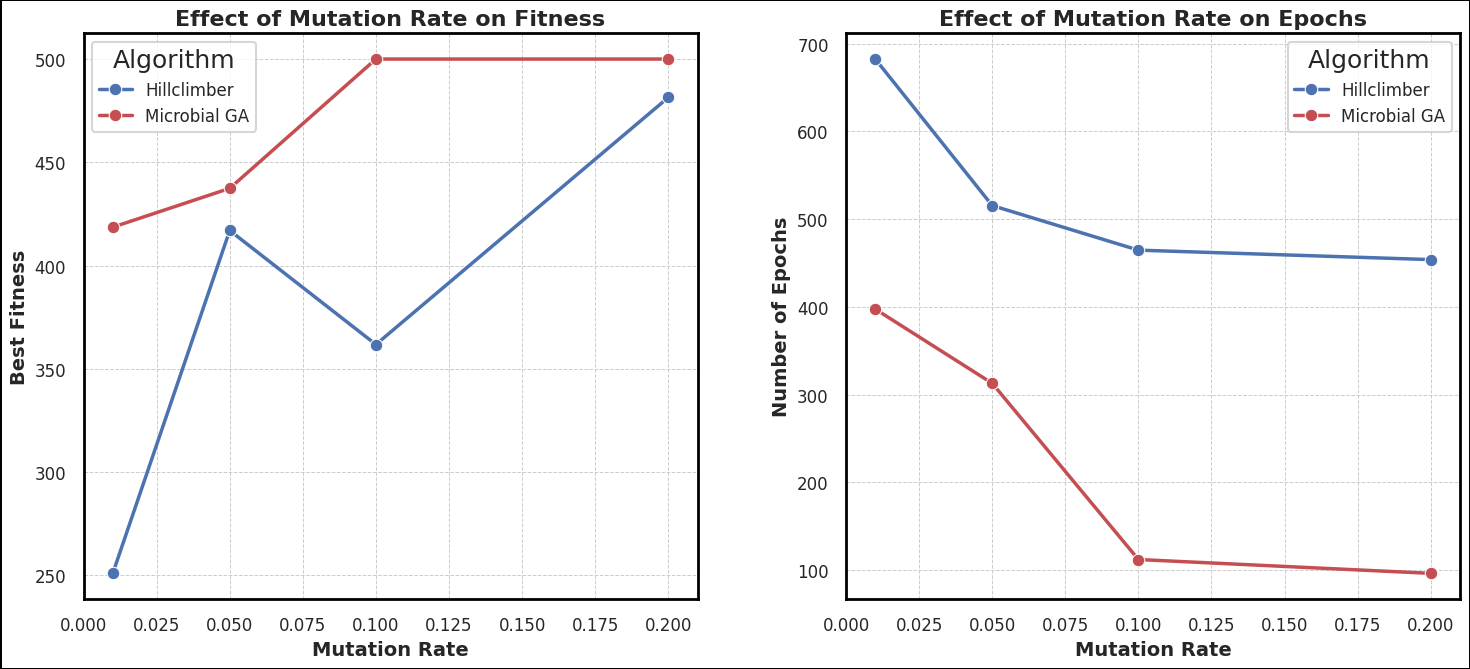

In [18]:
# Set seaborn style
sns.set(style="whitegrid", context="talk")

# Function to add borders to the plot
def add_borders(ax, border_color='black', border_width=2):
    for spine in ax.spines.values():
        spine.set_edgecolor(border_color)
        spine.set_linewidth(border_width)

# Initialize the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(16, 8), facecolor='white', edgecolor='black', linewidth=2)

# Define colors for each algorithm
colors = {'Hillclimber': 'b', 'Microbial GA': 'r'}

# Visualize the results
for algorithm in ['Hillclimber', 'Microbial GA']:
    subset = [r for r in results if r[0] == algorithm]
    mutation_rates, best_fitnesses, num_epochs = zip(*[(r[1], r[2], r[3]) for r in subset])

    # Plot for Best Fitness
    sns.lineplot(x=mutation_rates, y=best_fitnesses, marker='o', linewidth=2.5, ax=ax[0], label=algorithm, color=colors[algorithm])
    ax[0].set_xlabel('Mutation Rate', fontsize=14, weight='bold')
    ax[0].set_ylabel('Best Fitness', fontsize=14, weight='bold')
    ax[0].set_title('Effect of Mutation Rate on Fitness', fontsize=16, weight='bold')
    ax[0].grid(True, linestyle='--', linewidth=0.7)
    ax[0].tick_params(axis='both', which='major', labelsize=12)
    ax[0].set_xlim([min(mutation_rates) - 0.01, max(mutation_rates) + 0.01])
    add_borders(ax[0])

    # Plot for Number of Epochs
    sns.lineplot(x=mutation_rates, y=num_epochs, marker='o', linewidth=2.5, ax=ax[1], label=algorithm, color=colors[algorithm])
    ax[1].set_xlabel('Mutation Rate', fontsize=14, weight='bold')
    ax[1].set_ylabel('Number of Epochs', fontsize=14, weight='bold')
    ax[1].set_title('Effect of Mutation Rate on Epochs', fontsize=16, weight='bold')
    ax[1].grid(True, linestyle='--', linewidth=0.7)
    ax[1].tick_params(axis='both', which='major', labelsize=12)
    ax[1].set_xlim([min(mutation_rates) - 0.01, max(mutation_rates) + 0.01])
    add_borders(ax[1])

# Add legends to both plots
ax[0].legend(title='Algorithm', fontsize=12)
ax[1].legend(title='Algorithm', fontsize=12)

plt.tight_layout(pad=3.0)
plt.show()
